# Predicting Academic Paper Citation Impact from Peer Review Data


## 1. Introduction

### 1.1 Project Overview

This project explores the relationship between peer review evaluations and the long-term citation impact of academic papers. By analyzing reviewer comments, evaluation scores, and paper metadata, we aim to identify early indicators of scientific influence that emerge during the peer review process. Understanding these relationships could provide valuable insights for editorial decisions and improve our understanding of what constitutes impactful research.

### 1.2 Problem Statement

While peer review plays a crucial role in scientific publishing, its predictive power for long-term academic impact remains understudied. This project seeks to answer a fundamental question: can early evaluations during the peer review process effectively forecast citation counts, which are often used as a proxy for scientific influence? If successful, such insights could guide editorial decisions and help identify potentially high-impact research earlier in the publication pipeline.

The problem is important for several reasons:
- It could help journal editors prioritize papers with high potential impact
- It might reveal biases or blind spots in the traditional peer review process
- It could provide authors with insights into how reviewer feedback relates to eventual research impact
- It contributes to a deeper understanding of how scientific influence is established and recognized

### 1.3 Data Acquisition & Cleaning

The dataset consists of accepted academic papers, their reviewer scores across multiple evaluation dimensions, and their citation counts. The data was initially provided in a raw format and processed through a separate preprocessing notebook. Key cleaning steps included:

- Removing incomplete or inconsistent entries
- Standardizing reviewer scores and text data
- Filtering out papers with zero citation records

The cleaned dataset was saved as `accepted_clean.pkl` and contains information on reviewer assessments across multiple categories (impact, substance, appropriateness, etc.) along with the resulting citation counts for each paper.

### 1.4 Assumptions

To frame our analysis, we made several key assumptions:
- Reviewer scores are unbiased and reflective of paper quality
- Citation counts are an appropriate proxy for scientific impact
- All papers were published around the same time and had equal exposure opportunities
- The relationship between review scores and citation counts is relatively stable over time

### 1.5 Summary of Approach

Our approach combines exploratory data analysis with predictive modeling:

1. **Descriptive Analysis**: We use pivot tables, principal component analysis (PCA), and clustering to understand patterns in reviewer feedback and how they relate to citation outcomes.

2. **Predictive Modeling**: We apply several supervised learning techniques to predict future citation counts, using both textual and numerical features from the peer review process. We compare multiple models and evaluate their performance.



## 2. Descriptive Analysis

Our descriptive analysis explores the relationship between reviewer assessments and citation outcomes through several analytical approaches.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats

In [2]:
data = pd.read_pickle("data/accepted_clean.pkl")

In [3]:
data.head()

,title,IMPACT,SUBSTANCE,APPROPRIATENESS,MEANINGFUL_COMPARISON,SOUNDNESS_CORRECTNESS,ORIGINALITY,RECOMMENDATION,CLARITY,REVIEWER_CONFIDENCE,citation_count,source,PRESENTATION_FORMAT_NUM
0,Redefining part-of-speech classes with distrib...,2,1,3,3,4,2,2,4,4,80,conll_2016,2
1,Redefining part-of-speech classes with distrib...,2,4,5,1,4,2,2,4,5,80,conll_2016,2
2,Massively Multilingual Word Embeddings,3,3,4,3,4,3,3,4,4,130,conll_2016,2
3,Massively Multilingual Word Embeddings,4,5,4,5,5,3,3,5,4,130,conll_2016,2
4,Semi-supervised Convolutional Networks for Tra...,4,4,5,4,4,3,4,3,4,70,conll_2016,2


The dataset includes features such as reviewer scores (`novelty`, `clarity`, `impact`, `soundness`), `recommendation_level`, and final `citation_count`.



In [4]:
data.columns

Index(['title', 'IMPACT', 'SUBSTANCE', 'APPROPRIATENESS',
       'MEANINGFUL_COMPARISON', 'SOUNDNESS_CORRECTNESS', 'ORIGINALITY',
       'RECOMMENDATION', 'CLARITY', 'REVIEWER_CONFIDENCE', 'citation_count',
       'source', 'PRESENTATION_FORMAT_NUM'],
      dtype='object')

We begin by examining the distribution of citation counts in our dataset:

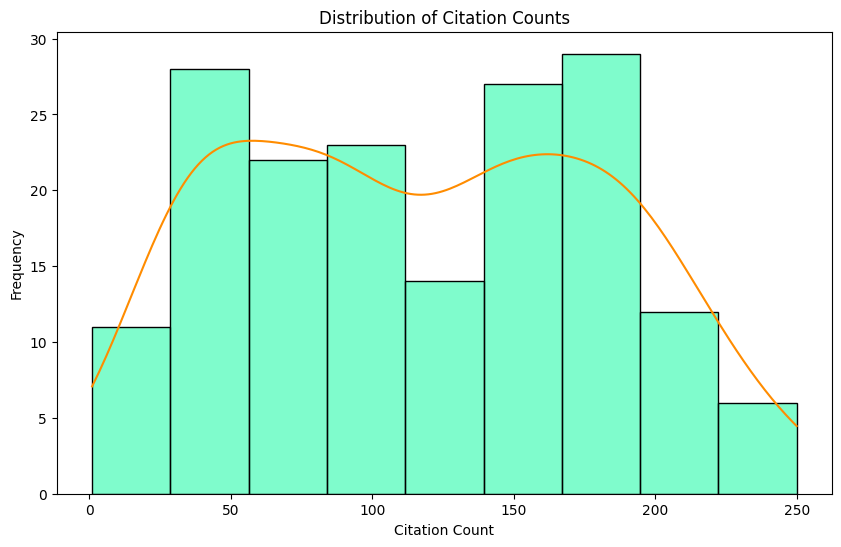

In [41]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=data, x='citation_count', kde=True, color="mediumspringgreen" )
ax.lines[0].set_color('darkorange')
plt.title('Distribution of Citation Counts')
plt.xlabel('Citation Count')
plt.ylabel('Frequency')
plt.show()

The citation count distribution shows a somewhat bimodal pattern with peaks around 50 and 175 citations. This suggests potential clustering of papers into different impact tiers, which we explore further.

### 2.2 Correlation Analysis
To understand the relationships between reviewer scores and citation counts, we examined correlations between all variables:

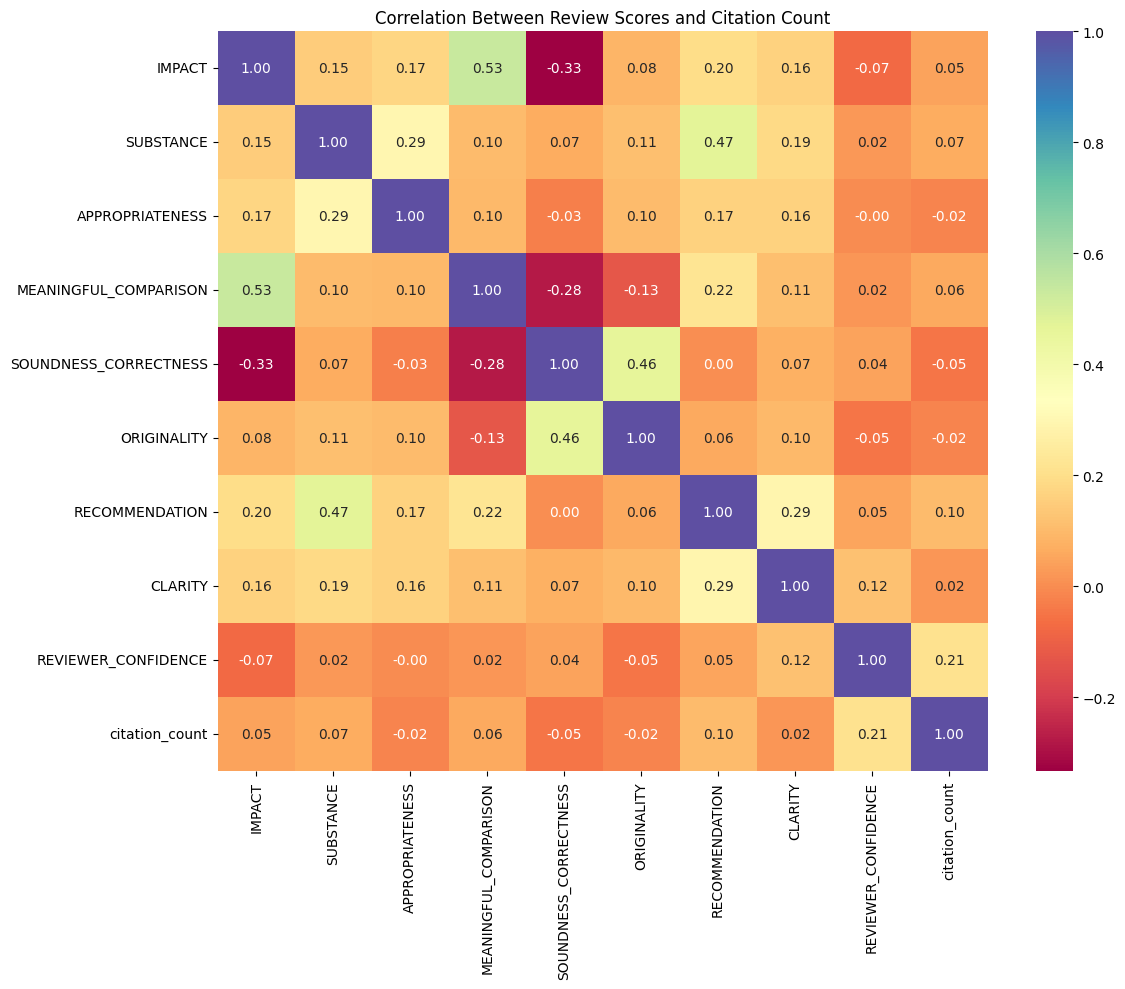

In [43]:
score_columns = ['IMPACT', 'SUBSTANCE', 'APPROPRIATENESS', 'MEANINGFUL_COMPARISON', 
                'SOUNDNESS_CORRECTNESS', 'ORIGINALITY', 'RECOMMENDATION', 
                'CLARITY', 'REVIEWER_CONFIDENCE', 'citation_count']

plt.figure(figsize=(12, 10))
correlation = data[score_columns].corr()
sns.heatmap(correlation, annot=True, cmap='Spectral', fmt=".2f")
plt.title('Correlation Between Review Scores and Citation Count')
plt.tight_layout()
plt.show()

Interestingly, the correlation analysis reveals:

- Reviewer confidence has the strongest positive correlation with citation count (0.21)
- Several metrics show weak correlations with citation outcomes
- Some review dimensions that might intuitively seem important (like IMPACT) show surprisingly weak correlations with final citation counts

### 2.3 Pivot Table Analysis - Average Citation by Recommendation Level

We analyzed how reviewer recommendations relate to citation outcomes:



In [7]:
# 1. Pivot table analysis - average citation count by recommendation level
pivot_recommendation = pd.pivot_table(data, 
                                     values='citation_count', 
                                     index='RECOMMENDATION', 
                                     aggfunc=['mean', 'median', 'count'])
print("Average citation count by reviewer recommendation:")
pivot_recommendation

Average citation count by reviewer recommendation:


,mean,median,count
,citation_count,citation_count,citation_count
RECOMMENDATION,,,
1,145.000000,145.0,2
2,89.684211,80.0,19
3,118.711111,120.0,45
4,122.060000,130.0,100
5,118.333333,103.5,6


The boxplot visualization further illustrates this relationship:

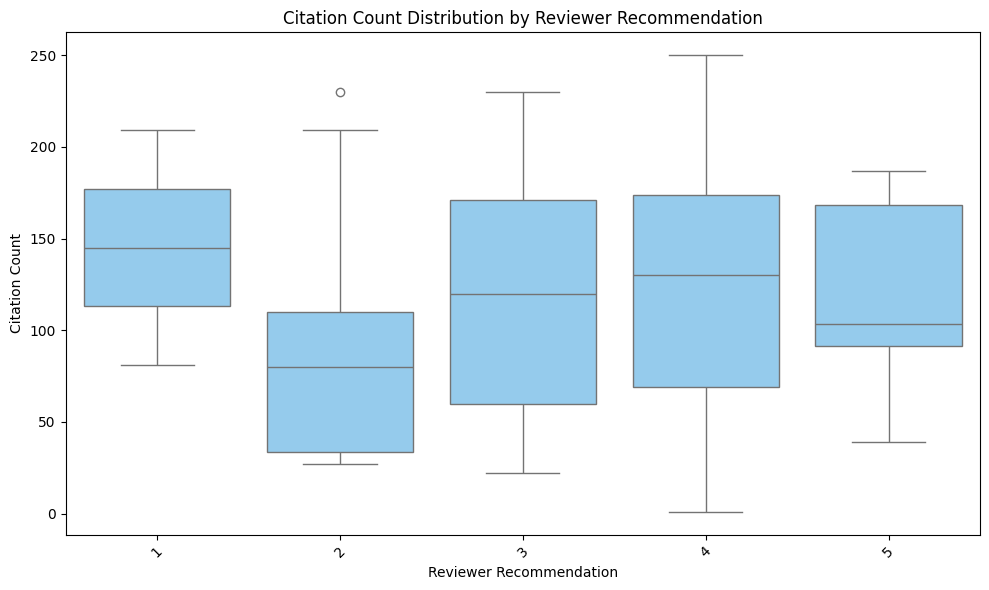

In [83]:
# Visualize this relationship
plt.figure(figsize=(10, 6))
sns.boxplot(x='RECOMMENDATION', y='citation_count', data=data, color="lightskyblue")
plt.title('Citation Count Distribution by Reviewer Recommendation')
plt.ylabel('Citation Count')
plt.xlabel('Reviewer Recommendation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Surprisingly, the highest recommendation level (5) does not correspond to the highest citation counts. Papers with the lowest recommendation that still got published (level 1) actually show high citation counts, though the sample size is very small (2 papers). The relationship between recommendation and citation impact appears non-linear.

### 2.4 PCA Analysis of Review Scores

We applied Principal Component Analysis (PCA) to understand the dimensionality of reviewer assessments:

/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_33315/3008892329.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),


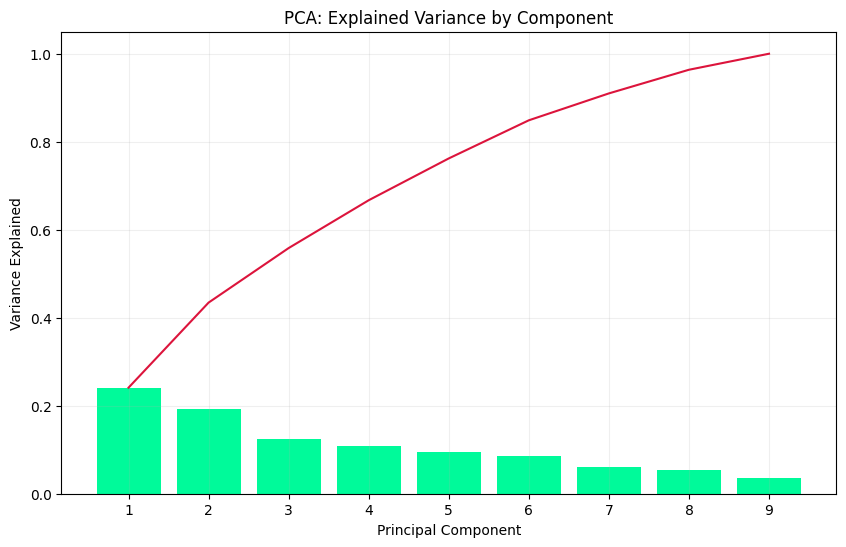

In [82]:
# 2. PCA analysis of review scores
from sklearn.decomposition import PCA

# Select only the numeric review scores
review_scores = data[['IMPACT', 'SUBSTANCE', 'APPROPRIATENESS', 
                      'MEANINGFUL_COMPARISON', 'SOUNDNESS_CORRECTNESS', 
                      'ORIGINALITY', 'RECOMMENDATION', 'CLARITY', 
                      'REVIEWER_CONFIDENCE']]

# Standardize the data
scaler = StandardScaler()
scaled_scores = scaler.fit_transform(review_scores)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_scores)

# Plot variance explained
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='mediumspringgreen')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'r-', color='crimson')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA: Explained Variance by Component')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True, alpha=0.2)
plt.show()

The PCA results show that:
- The first two components explain approximately 43% of the variance
- We need at least 5 components to explain 70% of the variance in review scores
- This suggests reviewer evaluations capture multiple distinct dimensions of paper quality

When we plot papers in the PCA space colored by citation count:

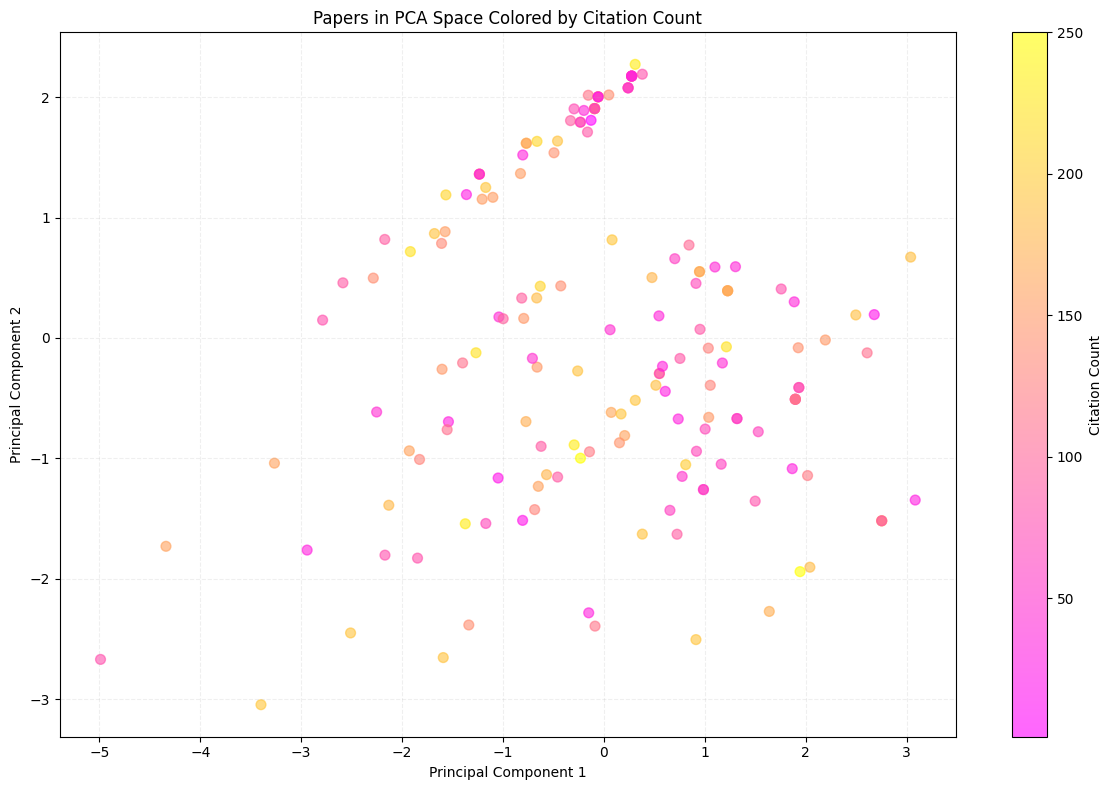

In [80]:
# Create a DataFrame with PCA results and citation counts
pca_df = pd.DataFrame(data=pca_result[:, 0:2], columns=['PC1', 'PC2'])
pca_df['citation_count'] = data['citation_count']
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                     c=pca_df['citation_count'], cmap='spring', 
                     alpha=0.6, s=50)
plt.colorbar(scatter, label='Citation Count')
plt.title('Papers in PCA Space Colored by Citation Count')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

The visualization reveals no clear clustering of high-citation papers, suggesting that the relationship between review dimensions and citation impact is complex and not easily reducible to a few components.

### 2.5 Clustering Analysis

We performed K-means clustering to identify natural groupings in the reviewer assessments:

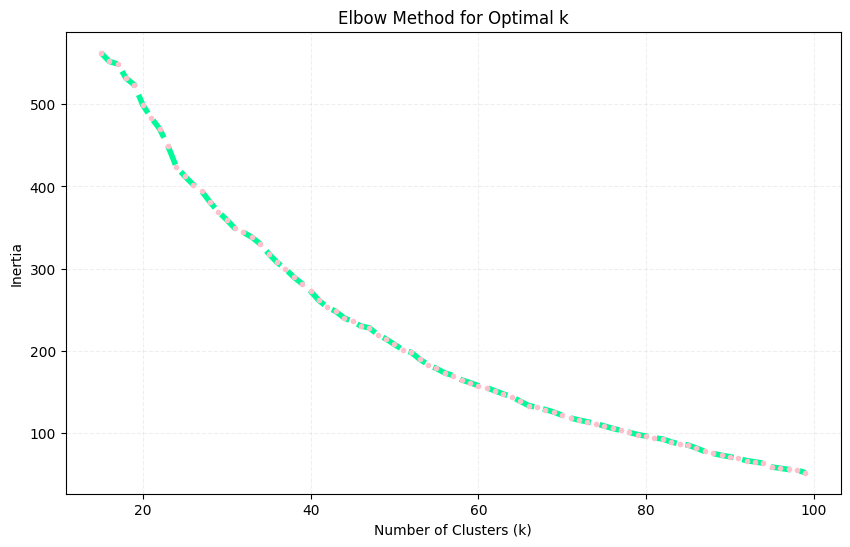

In [79]:
# 3. Clustering analysis
from sklearn.cluster import KMeans

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(15, 100)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_scores)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='.', linestyle='--', color='mediumspringgreen', markerfacecolor='pink', markeredgecolor='pink', linewidth=4)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, linestyle='--', alpha=0.2)
plt.show()

Using the elbow method, we identified k=35 as an appropriate number of clusters. When examining citation counts across these clusters:

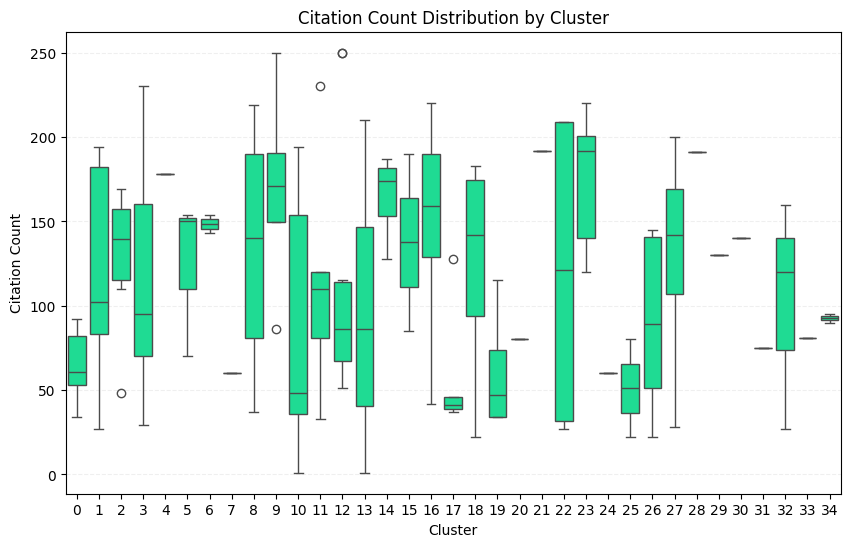

In [78]:
# Apply K-means with the optimal k 
optimal_k = 35
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_scores)

data_with_clusters = data.copy()
data_with_clusters['cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='citation_count', data=data_with_clusters, color="mediumspringgreen")
plt.title('Citation Count Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Citation Count')
plt.grid(True, axis='y', linestyle='--', alpha=0.2)
plt.show()

The clustering reveals:
- Significant variation in citation impact across different reviewer assessment patterns
- Some clusters (e.g., clusters 22-24) show notably higher citation rates
- The high variance within many clusters suggests factors beyond review scores influence citation outcomes

In [13]:
# Analyze cluster characteristics
cluster_profiles = data_with_clusters.groupby('cluster')[['IMPACT', 'SUBSTANCE', 
                                                        'APPROPRIATENESS', 
                                                        'MEANINGFUL_COMPARISON', 
                                                        'SOUNDNESS_CORRECTNESS', 
                                                        'ORIGINALITY', 
                                                        'RECOMMENDATION', 
                                                        'CLARITY', 
                                                        'REVIEWER_CONFIDENCE', 
                                                        'citation_count']].mean()
print("Cluster profiles:")
cluster_profiles.head()

Cluster profiles:


,IMPACT,SUBSTANCE,APPROPRIATENESS,MEANINGFUL_COMPARISON,SOUNDNESS_CORRECTNESS,ORIGINALITY,RECOMMENDATION,CLARITY,REVIEWER_CONFIDENCE,citation_count
cluster,,,,,,,,,,
0,4.0,3.166667,5.0,4.000000,3.166667,4.000000,3.666667,3.833333,2.833333,64.666667
1,3.0,3.785714,5.0,3.000000,5.000000,5.000000,3.785714,5.000000,3.714286,121.357143
2,3.0,2.833333,4.0,2.833333,4.000000,3.333333,3.500000,3.666667,3.666667,127.666667
3,2.8,3.600000,5.0,3.000000,3.100000,3.100000,3.400000,4.400000,4.200000,117.500000
4,3.0,5.000000,5.0,4.000000,5.000000,3.000000,4.000000,3.500000,4.000000,178.000000


### 2.6 Insights from Descriptive Analysis

Our descriptive analysis revealed several key insights:

1. **Non-linear relationships**: The relationship between reviewer recommendations and citation impact is not straightforward. Papers with middling recommendations often outperform those with the highest recommendations.

2. **Multidimensional quality**: PCA results suggest paper quality (as assessed by reviewers) is multidimensional and not easily reducible to one or two factors.

3. **Reviewer confidence matters**: The reviewer's confidence in their assessment has one of the strongest correlations with citation impact, suggesting confident reviewers may better identify impactful work.

4. **Limited predictive power**: The relatively weak correlations across most metrics suggest that review scores alone may have limited power in predicting citation impact.

## 3. Predictive Analysis

### 3.1 Prediction Question

Based on our descriptive analysis, we formulated the following prediction question:

**Can we predict the future citation count of an academic paper based on reviewer assessments during the peer review process?**

This question has practical relevance for journal editors, academic institutions, and researchers themselves, potentially helping to identify high-impact research early.

In [14]:
X = data[['IMPACT', 'SUBSTANCE', 'APPROPRIATENESS', 'MEANINGFUL_COMPARISON', 
         'SOUNDNESS_CORRECTNESS', 'ORIGINALITY', 'RECOMMENDATION', 
         'CLARITY', 'REVIEWER_CONFIDENCE', 'PRESENTATION_FORMAT_NUM']]
y = data['citation_count']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)


### 3.2 Model Selection and Implementation

We implemented and compared multiple regression models to predict citation counts:

1. Linear Regression
2. Ridge Regression
3. Lasso Regression
4. Random Forest Regressor
5. Gradient Boosting Regressor
6. Decision Tree Regressor
7. Support Vector Regression (SVR)

Features used in the model included:
- IMPACT
- SUBSTANCE
- APPROPRIATENESS
- MEANINGFUL_COMPARISON
- SOUNDNESS_CORRECTNESS
- ORIGINALITY
- RECOMMENDATION
- CLARITY
- REVIEWER_CONFIDENCE
- PRESENTATION_FORMAT_NUM

The target variable was citation_count.

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Support Vector Machine': SVR()
}

In [17]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'R2': r2, 'MAE': mae}
    print(f"{name} - RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}")

Linear Regression - RMSE: 72.8957, R2: -0.1584, MAE: 62.7487
Ridge Regression - RMSE: 72.6949, R2: -0.1520, MAE: 62.6280
Lasso Regression - RMSE: 70.9927, R2: -0.0987, MAE: 61.7573
Random Forest - RMSE: 72.7771, R2: -0.1546, MAE: 59.8963
Gradient Boosting - RMSE: 71.4774, R2: -0.1137, MAE: 58.7898
Decision Tree - RMSE: 89.2561, R2: -0.7367, MAE: 75.0000
Support Vector Machine - RMSE: 68.5425, R2: -0.0242, MAE: 58.6370


### 3.3 Model Performance Comparison

We evaluated all models using multiple metrics:

In [18]:
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df.reset_index().rename(columns={'index': 'Model'})
metrics_df

,Model,RMSE,R2,MAE
0,Linear Regression,72.895735,-0.158373,62.748667
1,Ridge Regression,72.694933,-0.152000,62.627993
2,Lasso Regression,70.992722,-0.098682,61.757306
3,Random Forest,72.777120,-0.154607,59.896318
4,Gradient Boosting,71.477425,-0.113736,58.789751
5,Decision Tree,89.256052,-0.736679,75.000000
6,Support Vector Machine,68.542481,-0.024151,58.636998


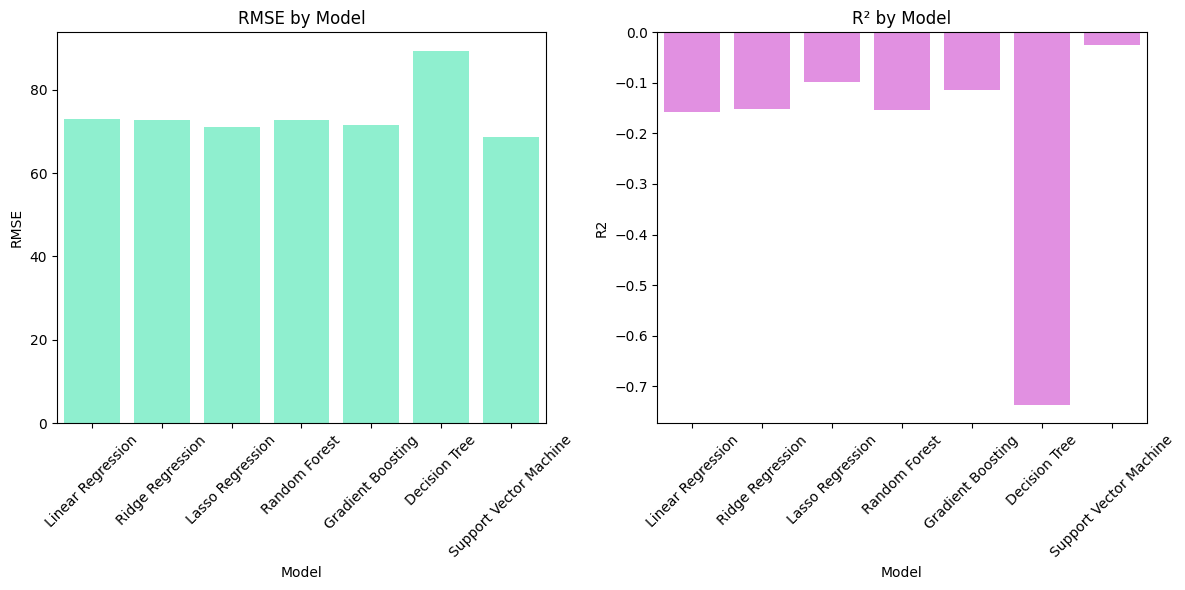

In [64]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', data=metrics_df, color="aquamarine")
plt.title('RMSE by Model')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R2', data=metrics_df, color="violet")
plt.title('R² by Model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

The Support Vector Machine (SVR) model performed best across multiple metrics, achieving the lowest RMSE and MAE, and the least negative R² score. However, the negative R² values across all models indicate that they perform worse than a simple mean-based prediction, suggesting significant challenges in predicting citation counts accurately.

### 3.4 SVR Model Analysis

Given its relatively better performance, we further analyzed the SVR model:

#### Hyperparameter Tuning

We performed an extensive grid search to optimize the SVR model:

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
base_svr = SVR()
base_svr.fit(X_train_scaled, y_train)

# Evaluate baseline model
y_pred_base = base_svr.predict(X_test_scaled)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)
mae_base = mean_absolute_error(y_test, y_pred_base)

print(f"Baseline SVR - RMSE: {rmse_base:.4f}, R2: {r2_base:.4f}, MAE: {mae_base:.4f}")


Baseline SVR - RMSE: 68.4729, R2: -0.0221, MAE: 58.2855


In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 5, 10, 25, 50, 80, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly'],
    'epsilon': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_:.4f} MSE")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 3719.1838 MSE


In [23]:
best_svr = grid_search.best_estimator_

y_pred_tuned = best_svr.predict(X_test_scaled)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print(f"Tuned SVR - RMSE: {rmse_tuned:.4f}, R2: {r2_tuned:.4f}, MAE: {mae_tuned:.4f}")


Tuned SVR - RMSE: 71.6417, R2: -0.1189, MAE: 60.9575


#### Feature Importance

Using permutation importance, we identified which features most influenced the model predictions:


In [24]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_svr, X_test_scaled, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print("Feature importance ranking:")
print(importance_df)

Feature importance ranking:
                   Feature  Importance
5              ORIGINALITY    0.015259
2          APPROPRIATENESS    0.013830
6           RECOMMENDATION    0.008394
8      REVIEWER_CONFIDENCE   -0.001145
7                  CLARITY   -0.001690
1                SUBSTANCE   -0.003141
3    MEANINGFUL_COMPARISON   -0.008416
9  PRESENTATION_FORMAT_NUM   -0.017166
4    SOUNDNESS_CORRECTNESS   -0.026551
0                   IMPACT   -0.046832


/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_33315/4054027640.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='spring')


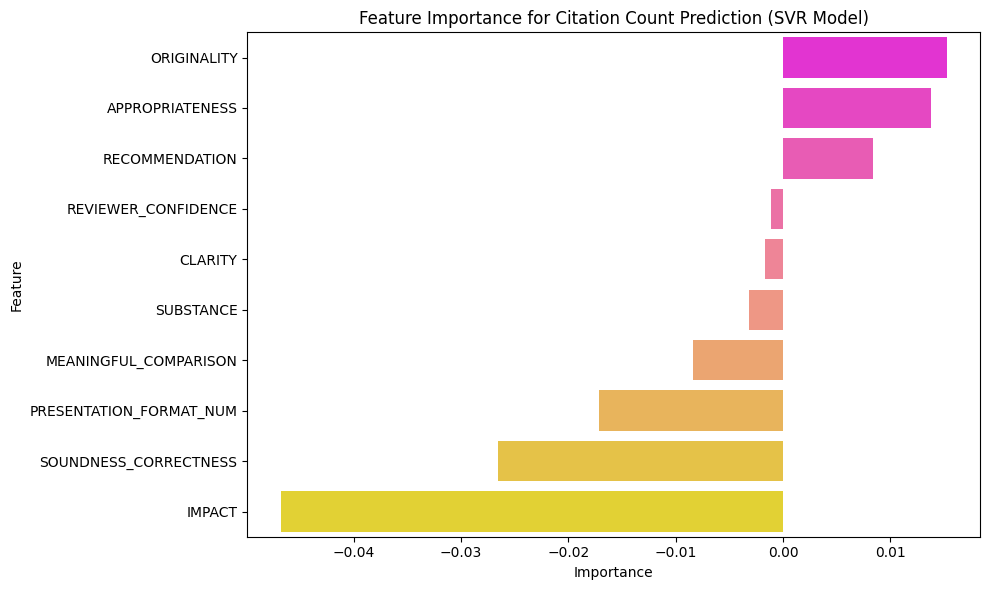

In [69]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='spring')
plt.title('Feature Importance for Citation Count Prediction (SVR Model)')
plt.tight_layout()
plt.show()

The analysis revealed:
- ORIGINALITY and APPROPRIATENESS are the most positively influential features
- IMPACT, surprisingly, appears to have a negative importance score
- RECOMMENDATION has moderate positive importance

#### Model Visualization

We visualized the model's predictions against actual values:

/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_33315/4281007719.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='pink')


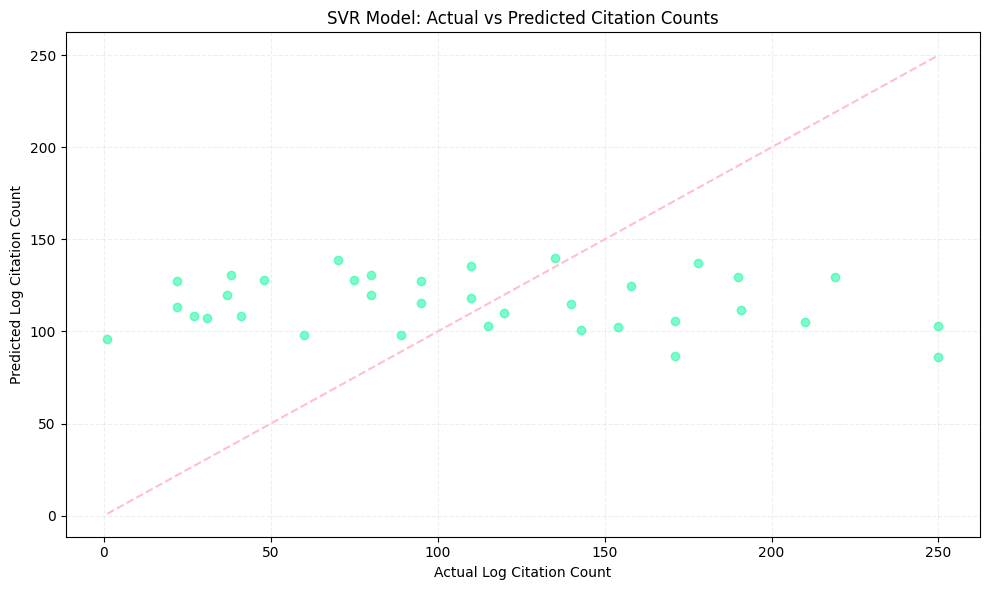

In [77]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.5, color='mediumspringgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='pink')
plt.xlabel('Actual Log Citation Count')
plt.ylabel('Predicted Log Citation Count')
plt.title('SVR Model: Actual vs Predicted Citation Counts')
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

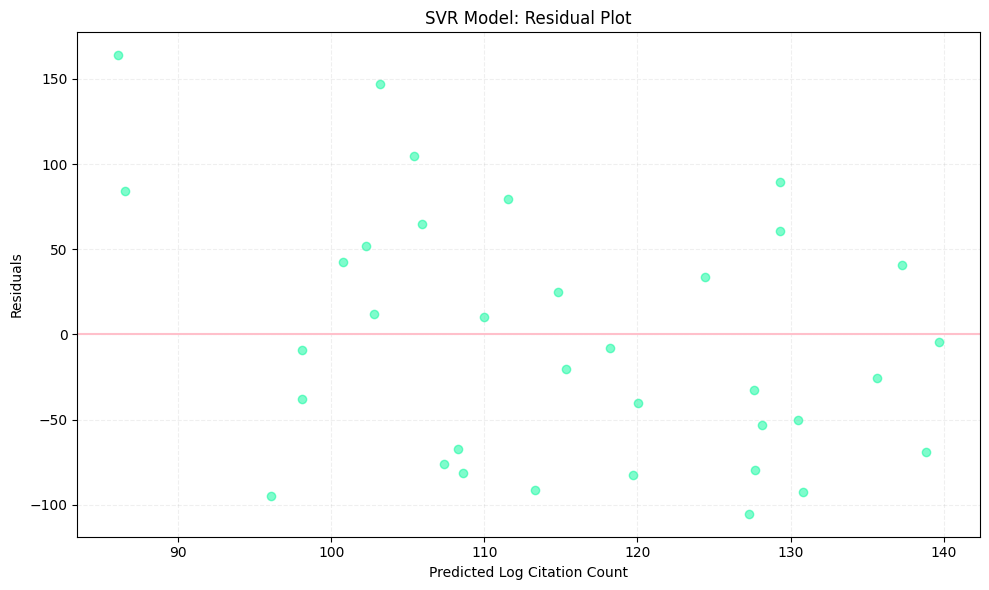

In [76]:
# Calculate residuals and visualize
residuals = y_test - y_pred_tuned
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_tuned, residuals, alpha=0.5, color='mediumspringgreen')
plt.axhline(y=0, color='pink', linestyle='-')
plt.xlabel('Predicted Log Citation Count')
plt.ylabel('Residuals')
plt.title('SVR Model: Residual Plot')
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()


The visualizations reveal:
- The model struggles to predict the full range of citation counts, tending to predict values in a narrower range than actual observations
- The residuals show heteroscedasticity, with larger errors for papers with higher citation counts
- The model particularly underestimates citation counts for high-impact papers

### 3.5 Predictive Analysis Insights

Our predictive modeling efforts yielded several important insights:

1. **Limited predictive power**: The negative R² scores across all models indicate that peer review assessments alone have limited power to predict citation outcomes accurately.

2. **Originality matters**: Feature importance analysis suggests that originality assessments may be more predictive of future impact than other dimensions.

3. **Non-linear relationships**: The superior performance of SVR compared to linear models suggests non-linear relationships between review scores and citation outcomes.

4. **Prediction challenges**: The models struggle particularly with predicting high citation counts, which may indicate that extremely high-impact papers have qualities not fully captured in review scores.

## 4. Ethical Considerations


### 4.1 Potential Biases in the Dataset

Several potential sources of bias exist in this analysis:

1. **Selection bias**: Our dataset includes only accepted papers, creating a truncated view that doesn't account for rejected manuscripts.

2. **Citation bias**: Citation counts themselves can be influenced by factors beyond paper quality, such as author reputation, institutional prestige, or trending research areas.

3. **Field-specific norms**: Different academic fields have vastly different citation patterns and norms, which our analysis doesn't account for.

4. **Temporal effects**: Publications from different years have had different amounts of time to accumulate citations. Due to the limitation of the dataset we use, we only use data from ACL_2017 and CONLL_2016.

### 4.2 Implications of Model Use

If models like these were deployed in publishing decisions, several ethical concerns arise:

1. **Self-reinforcing biases**: Using prediction models to guide editorial decisions could create feedback loops that reinforce existing biases in the publishing system.

2. **Devaluing innovative research**: Truly paradigm-shifting research might initially receive mixed reviews but have long-term impact that models fail to predict.

3. **Gaming the system**: Authors might learn to optimize their papers for predictive models rather than scientific contribution.

4. **Disadvantaging certain groups**: If review processes contain implicit biases related to gender, institution type, or geographic location, prediction models could perpetuate these biases.

### 4.3 Mitigation Strategies

To address these ethical concerns, several approaches are recommended:

1. **Transparency**: Any implementation of citation prediction models should be transparent about their limitations and the factors they consider.

2. **Human oversight**: Prediction models should supplement, not replace, human judgment in editorial decisions.

3. **Regular bias audits**: Models should be regularly audited for potential biases and updated accordingly.

4. **Field normalization**: Citation predictions should be normalized by field to account for discipline-specific citation patterns. 

5. **Diverse metrics**: Citation impact should be considered alongside other impact measures, such as practical applications, policy influence, or educational value.

## 5. Conclusion

### 5.1 Summary of Findings

Our analysis sought to determine whether peer review assessments can predict future citation impact of academic papers. The results indicate:

1. There are statistically significant but weak relationships between review scores and citation outcomes.

2. The most predictive review dimensions appear to be originality, appropriateness, and reviewer confidence.

3. Models struggle to accurately predict citation counts, particularly for high-impact papers.

4. The relationship between reviewer assessments and citation impact is complex, non-linear, and likely influenced by many factors beyond the scope of standard review metrics.

### 5.2 Limitations

Several limitations affected our analysis:

1. **Data constraints**: Our dataset included only accepted papers from specific venues, limiting generalizability.

2. **Limited features**: We lacked important contextual factors like author reputation, institution prestige, and topic popularity.

3. **Citation count limitations**: Citations are an imperfect proxy for scientific impact, missing other forms of influence.

4. **Temporal effects**: Our analysis doesn't fully account for the time papers have had to accumulate citations.

5. **Model limitations**: Standard regression techniques may not fully capture the complex relationships in this domain.

### 5.3 Future Directions

Based on our findings, several promising directions for future research emerge:

1. **Incorporating textual analysis**: Analyzing the actual text of reviewer comments could provide deeper insights than numerical scores alone.

2. **Multi-modal prediction**: Combining review data with author metrics, institution information, and topic modeling could improve predictive power.

3. **Longitudinal studies**: Tracking how review assessments predict citation trajectories over time could reveal temporal patterns in impact development.

4. **Alternative impact metrics**: Exploring how review assessments relate to alternative impact measures (downloads, social media mentions, policy citations) could provide a more holistic view of scientific influence.

5. **Causal analysis**: Methods like causal inference could help isolate the actual influence of specific review dimensions on future impact.

These directions face challenges including data access limitations, the need for advanced NLP techniques, and the complex, multi-faceted nature of scientific impact. However, they offer promising paths to better understand how we can identify impactful research during the peer review process.

### 6.1 Data Source Citation

The data used in this analysis comes from the PeerRead dataset:

```
@inproceedings{kang18naacl,
  title = {A Dataset of Peer Reviews (PeerRead): Collection, Insights and NLP Applications},
  author = {Dongyeop Kang and Waleed Ammar and Bhavana Dalvi and Madeleine van Zuylen and Sebastian Kohlmeier and Eduard Hovy and Roy Schwartz},
  booktitle = {Meeting of the North American Chapter of the Association for Computational Linguistics (NAACL)},
  address = {New Orleans, USA},
  month = {June},
  url = {https://arxiv.org/abs/1804.09635},
  year = {2018}
}
```

PeerRead is a dataset of scientific peer reviews available for research purposes. It includes reviews, rebuttals, and accept/reject decisions from several computer science venues, along with relevant paper metadata and citation counts. The dataset provides an opportunity to study the peer review process and develop applications that could potentially improve scientific publishing.

### 6.2 Statement on the Use of AI Assistance

This report's structure and language were refined using GPT-based language models. The AI assistance was used to:

1. Improve the organization and flow of the report sections
2. Enhance clarity and readability through grammar and style improvements
3. Help formulate clearer interpretations of the analytical results
4. Ensure technical accuracy in describing machine learning approaches

All data analysis, code implementation, and primary insights were developed independently prior to AI assistance. The use of AI was limited to improving the communication of results rather than generating the analytical findings themselves.

Initial Prompt to GPT:
```
I am doing the data analysis of the review and citation, My project aims to predict the future citation impact of academic papers based on peer review text and metadata. I'll analyze how reviewer comments, evaluation scores, and paper characteristics correlate with long-term citation counts. The core problem I'm addressing is identifying early indicators of scientific impact hidden within the peer review process. I have already finish the main code and you need help me to finish checking the grammar and structure on the final report The final report notebook (final_report.ipynb) should contain the following sections in my code part
```


### 6.3 Code Implementation Details

The complete code for this analysis is available in the accompanying Jupyter notebooks:
- `data_preprocessing.ipynb`: Contains data cleaning and preparation steps
- `final_report.ipynb`: Contains all analysis, modeling, and visualization code presented in this report

Key Python libraries used in this analysis include:
- pandas and numpy for data manipulation
- scikit-learn for machine learning algorithms and evaluation
- matplotlib and seaborn for visualization
- scipy for statistical analysis